## Processing Ocean Color Imagery - Process Micasense Images

Pull in all images and process with micasense tools
    normalize and align and whatnot
    put these into functions and clean up
    also visualize along the way and look at distributions to think about whether or not they're legitimate
    write out
    
Pull in all images as modified and metadata with specific functions
    Visualize for issues and shadows and bright spots and locations
    correct for sky radiance
    visualize the distributions of both sky (clouds) and sea
    look at the variability of spectra both for specific pixels and across nearby images
    filter for orientation and location and issues

take the water leaving spectra and convert to chla as well as other future products and just intro general analysis of spectra
    produce a csv or .shp or images of ocean color products 
    

In [36]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
from ipywidgets import FloatProgress, Layout
from IPython.display import display
from micasense import imageset as imageset
from micasense import capture as capture
import multiprocessing
import glob, shutil, os

import cv2
import numpy as np
import matplotlib.pyplot as plt


import micasense.imageutils as imageutils
import micasense.plotutils as plotutils

import exiftool
import datetime

import subprocess
import math


### Helper Functions

In [2]:
def process_panel_img(panelNames, panelCorners=None, useDLS = True):
    location = None
    utc_time = None
    panel_irradiance = None
    if panelNames is not None:
        panelCap = capture.Capture.from_filelist(panelNames)
        if panelCorners:
            panelCap.set_panelCorners(panelCorners)
        location = panelCap.location()
        utc_time = panelCap.utc_time()
    else:
        panelCap = None

    if panelCap is not None:
        if panelCap.panel_albedo() is not None and not any(v is None for v in panelCap.panel_albedo()):
            panel_reflectance_by_band = panelCap.panel_albedo()
        else:
            #panel_reflectance_by_band = [0.67, 0.69, 0.68, 0.61, 0.67] #RedEdge band_index order
            panel_reflectance_by_band = [0.493, 0.493, 0.492, 0.489, 0.491]

        panel_irradiance = panelCap.panel_irradiance(panel_reflectance_by_band)    
        img_type = "reflectance"
    else:
        if useDLS:
            img_type='reflectance'
        else:
            img_type = "radiance"
    return(panel_irradiance, img_type, location, utc_time)

In [3]:
def get_warp_matrix(img_capture, max_alignment_iterations = 50):
    # TODO does this need img_type???
    # TODO ensure this is good for the Altum
    ## Alignment settings
    match_index = 2 # Index of the band 
    warp_mode = cv2.MOTION_HOMOGRAPHY # MOTION_HOMOGRAPHY or MOTION_AFFINE. For Altum images only use HOMOGRAPHY
    pyramid_levels = 0 # for images with RigRelatives, setting this to 0 or 1 may improve alignment
    print("Aligning images. Depending on settings this can take from a few seconds to many minutes")
    # Can potentially increase max_iterations for better results, but longer runtimes
    warp_matrices, alignment_pairs = imageutils.align_capture(img_capture,
                                                              ref_index = match_index,
                                                              max_iterations = max_alignment_iterations,
                                                              warp_mode = warp_mode,
                                                              pyramid_levels = pyramid_levels)

    #print("Finished Aligning, warp matrices={}".format(warp_matrices))
    return(warp_matrices)



In [4]:
def decdeg2dms(dd):
    is_positive = dd >= 0
    dd = abs(dd)
    minutes,seconds = divmod(dd*3600,60)
    degrees,minutes = divmod(minutes,60)
    degrees = degrees if is_positive else -degrees
    return (degrees,minutes,seconds)


def write_exif_csv(img_set, outputPath):
    header = "SourceFile,\
    GPSDateStamp,GPSTimeStamp,\
    GPSLatitude,GpsLatitudeRef,\
    GPSLongitude,GPSLongitudeRef,\
    GPSAltitude,GPSAltitudeRef,\
    FocalLength,\
    XResolution,YResolution,ResolutionUnits,\
    GPSImgDirection,GPSPitch,GPSRoll\n"

    lines = [header]
    for capture in img_set.captures:
        #get lat,lon,alt,time
        outputFilename = capture.uuid+'.tif'
        fullOutputPath = os.path.join(outputPath, outputFilename)
        lat,lon,alt = capture.location()
        #write to csv in format:
        # IMG_0199_1.tif,"33 deg 32' 9.73"" N","111 deg 51' 1.41"" W",526 m Above Sea Level
        latdeg, latmin, latsec = decdeg2dms(lat)
        londeg, lonmin, lonsec = decdeg2dms(lon)
        latdir = 'North'
        if latdeg < 0:
            latdeg = -latdeg
            latdir = 'South'
        londir = 'East'
        if londeg < 0:
            londeg = -londeg
            londir = 'West'
        resolution = capture.images[0].focal_plane_resolution_px_per_mm
        
        yaw, pitch, roll = capture.dls_pose()
        yaw, pitch, roll = np.array([yaw, pitch, roll]) * 180/math.pi

        linestr = '"{}",'.format(fullOutputPath)
        linestr += capture.utc_time().strftime("%Y:%m:%d,%H:%M:%S,")
        linestr += '"{:d} deg {:d}\' {:.2f}"" {}",{},'.format(int(latdeg),int(latmin),latsec,latdir[0],latdir)
        linestr += '"{:d} deg {:d}\' {:.2f}"" {}",{},{:.1f} m Above Sea Level,Above Sea Level,'.format(int(londeg),int(lonmin),lonsec,londir[0],londir,alt)
        linestr += '{},'.format(capture.images[0].focal_length)
        linestr += '{},mm,'.format(resolution)
        linestr += '{},{},{}'.format(yaw, pitch, roll)
        linestr += '\n' # when writing in text mode, the write command will convert to os.linesep
        lines.append(linestr)

    fullCsvPath = os.path.join(outputPath,'log.csv')
    with open(fullCsvPath, 'w') as csvfile: #create CSV
        csvfile.writelines(lines)
        
    return(fullCsvPath)

In [5]:
def save_images(img_set, outputPath, thumbnailPath, panel_irradiance, warp_img_capture, generateThumbnails = True, overwrite=False):
    """
    This function does ther actual processing of running through each capture within an imageset
    and saving as a .tiff.
    
    TODO change this to save images with rasterio as proper rasters
        only really necessary if we're going to map as opposed to use imgs as samples
    """
    # TODO this isn't working, these image alignments are terrible...
    # actually on the Altum they are very good
    # you need a relatively flat image and it should be at the same altitude
    # see https://github.com/micasense/imageprocessing/blob/de96aad06fc32a35597a8264190f81cd35206383/Alignment.ipynb
    warp_matrices = get_warp_matrix(warp_img_capture)

    if not os.path.exists(outputPath):
        os.makedirs(outputPath)
    if generateThumbnails and not os.path.exists(thumbnailPath):
        os.makedirs(thumbnailPath)

    # Save out geojson data so we can open the image capture locations in our GIS
    # with open(os.path.join(outputPath,'imageSet.json'),'w') as f:
    #     f.write(str(geojson_data))

    try:
        irradiance = panel_irradiance+[0]
    except NameError:
        irradiance = None
    except TypeError:
        irradiance = None

    start = datetime.datetime.now()
    for i,capture in enumerate(img_set.captures):
        outputFilename = capture.uuid+'.tif'
        thumbnailFilename = capture.uuid+'.jpg'
        fullOutputPath = os.path.join(outputPath, outputFilename)
        fullThumbnailPath= os.path.join(thumbnailPath, thumbnailFilename)
        if (not os.path.exists(fullOutputPath)) or overwrite:
            if(len(capture.images) == len(img_set.captures[0].images)):
                capture.compute_undistorted_reflectance(irradiance_list=irradiance,force_recompute=True)
                capture.create_aligned_capture(irradiance_list=irradiance, warp_matrices=warp_matrices)
                capture.save_capture_as_stack(fullOutputPath, sort_by_wavelength=True)
                if generateThumbnails:
                    capture.save_capture_as_rgb(fullThumbnailPath)
        capture.clear_image_data()
    end = datetime.datetime.now()

    print("Saving time: {}".format(end-start))
    print("Alignment+Saving rate: {:.2f} images per second".format(float(len(img_set.captures))/float((end-start).total_seconds())))
    return(True)

In [6]:
def write_img_exif(fullCsvPath, outputPath):  
    if os.environ.get('exiftoolpath') is not None:
        exiftool_cmd = os.path.normpath(os.environ.get('exiftoolpath'))
    else:
        exiftool_cmd = 'exiftool'

    cmd = '{} -csv="{}" -overwrite_original {}'.format(exiftool_cmd, fullCsvPath, outputPath)
    print(cmd)
    #subprocess.check_call(cmd)
    return(True)

In [7]:
# TODO could make a function that splits the full images up into panel and sea and sky

### Primary Processing Function

In [13]:
def process_micasense_subset(img_dir, panelNames, warp_img_dir=None, overwrite=False, panelCorners=None):
    """
    Testing function that takes in an image directorie and saves out processed imagery
    
    Various visualization functions for deciding ideal processing parameters
    
    """
    # ideally this goes through and picks out all panels and then chooses the closest one
    # right now it just takes one
    panel_irradiance, img_type, location, utc_time = process_panel_img(panelNames,panelCorners=panelCorners)
    if panel_irradiance:
        print("Panel irradiance calculated.")
    else:
        print("Not using panel irradiance.")
        
    imgset = imageset.ImageSet.from_directory(img_dir)
    
    if warp_img_dir:
        warp_img_capture = imageset.ImageSet.from_directory(warp_img_dir).captures[0]
        print('used warp dir', warp_img_dir)
    else:
        warp_img_capture = imgset.captures[0]
        
    outputPath = os.path.join(img_dir,'stacks')
    thumbnailPath = os.path.join(img_dir, 'thumbnails')
    
    if save_images(imgset, outputPath, thumbnailPath, panel_irradiance, warp_img_capture, overwrite=overwrite) == True:
        print("Finished saving images.")
        fullCsvPath = write_exif_csv(imgset, outputPath)
        if write_img_exif(fullCsvPath, outputPath) == True:        
            print("Finished saving image metadata.")
            
    return(outputPath)

In [9]:
def process_micasense_images(sea_dir, sky_dir, panelNames, overwrite=False, panelCorners=None):
    """
    Primary function that takes in sea and sky image directories and saves out processed imagery
    
    Various visualization functions for deciding ideal processing parameters
    
    """
    # ideally this goes through and picks out all panels and then chooses the closest one
    # right now it just takes one
    panel_irradiance, img_type, location, utc_time = process_panel_img(panelNames,panelCorners=panelCorners)
    if panel_irradiance:
        print("Panel irradiance calculated.")
    else:
        print("Not using panel irradiance.")
    
    # also will need to integrate the DLS as an alternative
    
    seaimgset = imageset.ImageSet.from_directory(sea_dir)
    seaOutputPath = os.path.join(sea_dir,'..','seastacks')
    seathumbnailPath = os.path.join(sea_dir, '..', 'seathumbnails')
    
    skyimgset = imageset.ImageSet.from_directory(sky_dir)
    skyOutputPath = os.path.join(sky_dir,'..','skystacks')
    skythumbnailPath = os.path.join(sky_dir, '..', 'skythumbnails')
    
    if save_images(skyimgset, skyOutputPath, skythumbnailPath, panel_irradiance, overwrite=overwrite) == True:
        print("Finished saving sky images.")
        fullCsvPath = write_exif_csv(skyimgset, skyOutputPath)
        if write_img_exif(fullCsvPath, skyOutputPath) == True:        
            print("Finished saving sky image metadata.")
    
    if save_images(seaimgset, seaOutputPath, seathumbnailPath, panel_irradiance, overwrite=overwrite) == True:
        print("Finished saving sea images.")
        fullCsvPath = write_exif_csv(seaimgset, seaOutputPath)
        if write_img_exif(fullCsvPath, seaOutputPath) == True:
            print("Finished saving sea image metadata.")
            
    return(seaOutputPath, skyOutputPath)

### Run the process

#### first sort the images into sea and sky

In [10]:
! pwd

/home/clifgray/Code/ocean_color


In [11]:
all_img_dir = os.path.join('data', '170321_duml_testing', '360_test', 'all_imgs')
sky_dst = os.path.join('data', '170321_duml_testing', '360_test', 'sky')
sea_dst = os.path.join('data', '170321_duml_testing', '360_test', 'sea')

In [34]:
if not os.path.exists(sky_dst):
    os.makedirs(sky_dst)

if not os.path.exists(sea_dst):
    os.makedirs(sea_dst)

down_image_count = 10
up_image_count = 2

#go through each image
i = 0
j = 0
for file in sorted(glob.glob(all_img_dir+ "/*.tif")):
    if i < down_image_count*6:
        shutil.move(file, sea_dst)
        i += 1
        if i == down_image_count*6:
            j = 0
    elif j < up_image_count*6:
        shutil.move(file, sky_dst)
        j += 1
        if j == up_image_count*6:
            i = 0

#### Now the real processing code

In [11]:
! ls data/20210317_duml_360_altitude_testing/altitude_test/panel

IMG_0494_1.tif	IMG_0494_4.tif	IMG_0495_1.tif	IMG_0495_4.tif
IMG_0494_2.tif	IMG_0494_5.tif	IMG_0495_2.tif	IMG_0495_5.tif
IMG_0494_3.tif	IMG_0494_6.tif	IMG_0495_3.tif	IMG_0495_6.tif


In [14]:
glob.glob(os.path.join('data', '20210317_duml_360_altitude_testing', 'altitude_test', 'panel', 'IMG_0495*.tif'))

['data/20210317_duml_360_altitude_testing/altitude_test/panel/IMG_0495_2.tif',
 'data/20210317_duml_360_altitude_testing/altitude_test/panel/IMG_0495_5.tif',
 'data/20210317_duml_360_altitude_testing/altitude_test/panel/IMG_0495_3.tif',
 'data/20210317_duml_360_altitude_testing/altitude_test/panel/IMG_0495_1.tif',
 'data/20210317_duml_360_altitude_testing/altitude_test/panel/IMG_0495_6.tif',
 'data/20210317_duml_360_altitude_testing/altitude_test/panel/IMG_0495_4.tif']

check the panel is good

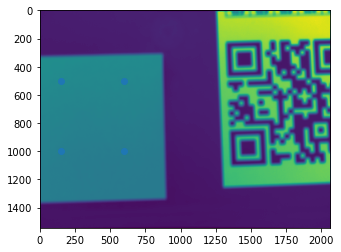

In [37]:
fig, ax = plt.subplots()

ax.imshow(img.undistorted_radiance())
ax.scatter([150,150,600,600], [500,1000,1000,500])

Detected panel serial: None
Extracted Panel Statistics:
Mean: 30093.75835026178
Standard Deviation: 2454.3726500896714
Panel Pixel Count: 225951
Saturated Pixel Count: 0


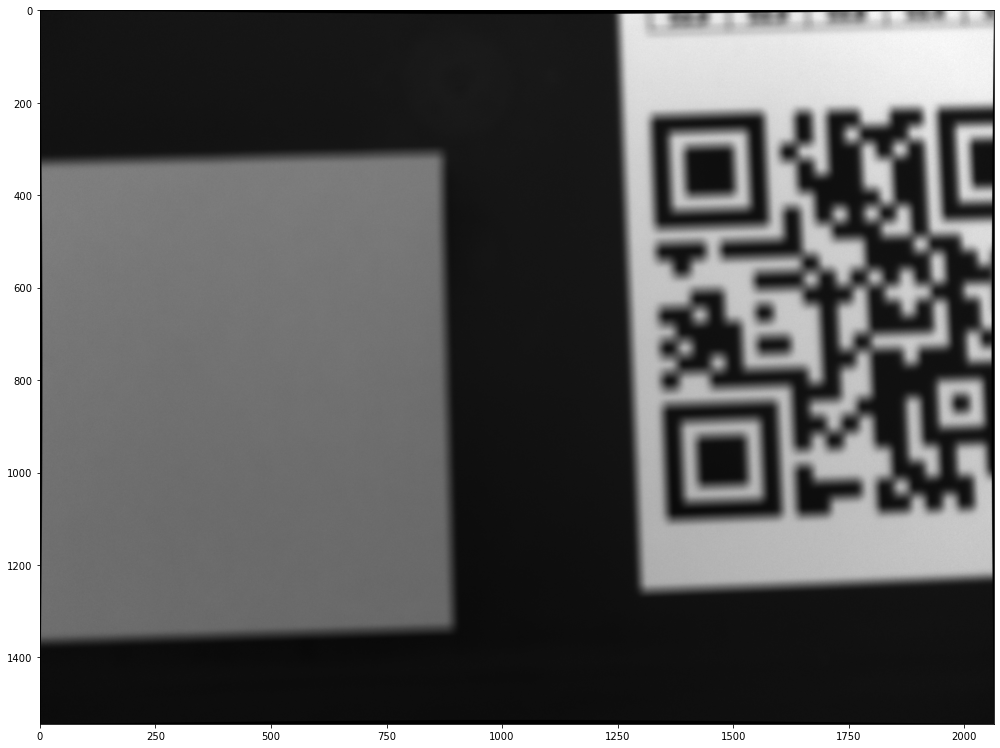

In [18]:
from micasense.image import Image
from micasense.panel import Panel

imageName = glob.glob(os.path.join('data', '20210317_duml_360_altitude_testing', 'altitude_test', 'panel', 'IMG_0494_1.tif'))[0]

img = Image(imageName)
if img.auto_calibration_image:
    print("Found automatic calibration image")
    panel = Panel(img)
else:
    panel = Panel(img,panelCorners=[[150, 500], [150, 1000], [600, 1000], [600, 500]])

# if not panel.panel_detected():
#     raise IOError("Panel Not Detected!")
    
print("Detected panel serial: {}".format(panel.serial))
mean, std, num, sat_count = panel.raw()
print("Extracted Panel Statistics:")
print("Mean: {}".format(mean))
print("Standard Deviation: {}".format(std))
print("Panel Pixel Count: {}".format(num))
print("Saturated Pixel Count: {}".format(sat_count))
panel.plot();


In [10]:
! ls data/20210404_duml_rho_correction_testing/

0009SET  panel	sky  sun_blocked  surface


In [45]:
warp_img_dir

'data/20210317_duml_360_altitude_testing/varying_altitude'

In [51]:
panelNames = None
#panelNames = glob.glob(os.path.join('data', '20210317_duml_360_altitude_testing', 'altitude_test', 'panel', 'IMG_0494_*.tif'))
alt_dir = os.path.join('data', '20210317_duml_360_altitude_testing', 'altitude_test', 'varying_altitude')

warp_img_dir = os.path.join('data', '20210317_duml_360_altitude_testing', 'altitude_test', 'varying_altitude')

altitude_out = process_micasense_subset(alt_dir, panelNames, warp_img_dir, overwrite=False)

Not using panel irradiance.
used warp dir data/20210317_duml_360_altitude_testing/altitude_test/varying_altitude
Aligning images. Depending on settings this can take from a few seconds to many minutes
Finished aligning band 2
Finished aligning band 1
Finished aligning band 0
Finished aligning band 3
Finished aligning band 4
Saving time: 0:17:05.402282
Alignment+Saving rate: 0.33 images per second
Finished saving images.
exiftool -csv="data/20210317_duml_360_altitude_testing/altitude_test/varying_altitude/stacks/log.csv" -overwrite_original data/20210317_duml_360_altitude_testing/altitude_test/varying_altitude/stacks
Finished saving image metadata.


In [ ]:
panelNames = glob.glob(os.path.join('data', '20210317_duml_360_altitude_testing', 'altitude_test', 'panel', 'IMG_0494_*.tif'))
alt_dir = os.path.join('data', '20210317_duml_360_altitude_testing', 'altitude_test', 'varying_altitude')

warp_img_dir = os.path.join('data', '20210317_duml_360_altitude_testing', 'panel')

altitude_out = process_micasense_subset(alt_dir, panelNames, warp_img_dir, overwrite=False, panelCorners=[[150, 500], [150, 1000], [600, 1000], [600, 500]])

In [11]:
! ls data/20210404_duml_rho_correction_testing/

0009SET  panel	sky  sun_blocked  surface


In [14]:
panelNames = glob.glob(os.path.join('data', '20210404_duml_rho_correction_testing', 'panel', 'IMG_0000_*.tif'))
blocked_dir = os.path.join('data', '20210404_duml_rho_correction_testing', 'sun_blocked')
surface_dir = os.path.join('data', '20210404_duml_rho_correction_testing', 'surface')
sky_dir = os.path.join('data', '20210404_duml_rho_correction_testing', 'sky')

warp_img_dir = os.path.join('data', '20210404_duml_rho_correction_testing', 'panel')

sunlight_blocked_out = process_micasense_subset(blocked_dir, panelNames, warp_img_dir, overwrite=False)
surface_out = process_micasense_subset(surface_dir, panelNames, warp_img_dir, overwrite=False)
sky_out = process_micasense_subset(sky_dir, panelNames, warp_img_dir, overwrite=False)

Panel irradiance calculated.
used warp dir data/20210404_duml_rho_correction_testing/panel
Aligning images. Depending on settings this can take from a few seconds to many minutes
Finished aligning band 2
Finished aligning band 1
Finished aligning band 4
Finished aligning band 0
Finished aligning band 3
Saving time: 0:00:11.196770
Alignment+Saving rate: 0.63 images per second
Finished saving images.
exiftool -csv="data/20210404_duml_rho_correction_testing/sun_blocked/stacks/log.csv" -overwrite_original data/20210404_duml_rho_correction_testing/sun_blocked/stacks
Finished saving image metadata.
Panel irradiance calculated.
used warp dir data/20210404_duml_rho_correction_testing/panel
Aligning images. Depending on settings this can take from a few seconds to many minutes
Finished aligning band 2
Finished aligning band 0
Finished aligning band 1
Finished aligning band 4
Finished aligning band 3
Saving time: 0:00:20.457552
Alignment+Saving rate: 0.78 images per second
Finished saving images

In [15]:
! exiftool -csv="data/20210404_duml_rho_correction_testing/sun_blocked/stacks/log.csv" -overwrite_original data/20210404_duml_rho_correction_testing/sun_blocked/stacks

    1 directories scanned
    7 image files updated


In [16]:
! exiftool -csv="data/20210404_duml_rho_correction_testing/surface/stacks/log.csv" -overwrite_original data/20210404_duml_rho_correction_testing/surface/stacks

    1 directories scanned
   16 image files updated


In [17]:
! exiftool -csv="data/20210404_duml_rho_correction_testing/sky/stacks/log.csv" -overwrite_original data/20210404_duml_rho_correction_testing/sky/stacks

    1 directories scanned
    7 image files updated


In [19]:
! exiftool -csv="data/20210330_duml_sunlight_blocked_testing/tube_sea/stacks/log.csv" -overwrite_original data/20210330_duml_sunlight_blocked_testing/tube_sea/stacks

    1 directories scanned
   20 image files updated


In [35]:
#panelNames = glob.glob(os.path.join('data', '130920_shearwatergulf_rededge', '0013SET', 'panel','IMG_0001_*.tif'))
panelNames = None
sky_dir = os.path.join('data', '170321_duml_testing', '360_test', 'sky')
sea_dir = os.path.join('data', '170321_duml_testing', '360_test', 'sea')

sea_output, sky_output = process_micasense_images(sea_dir, sky_dir, panelNames, overwrite=True)

Not using panel irradiance.
Aligning images. Depending on settings this can take from a few seconds to many minutes
Finished aligning band 1
Finished aligning band 2
Finished aligning band 0
Finished aligning band 3
Finished aligning band 4
Saving time: 0:03:05.610782
Alignment+Saving rate: 0.33 images per second
Finished saving sky images.
exiftool -csv="data/170321_duml_testing/360_test/sky/../skystacks/log.csv" -overwrite_original data/170321_duml_testing/360_test/sky/../skystacks
Finished saving sky image metadata.
Aligning images. Depending on settings this can take from a few seconds to many minutes
Finished aligning band 1
Finished aligning band 3
Finished aligning band 2
Finished aligning band 4
Finished aligning band 0
Saving time: 0:16:43.015218
Alignment+Saving rate: 0.32 images per second
Finished saving sea images.
exiftool -csv="data/170321_duml_testing/360_test/sea/../seastacks/log.csv" -overwrite_original data/170321_duml_testing/360_test/sea/../seastacks
Finished savin

In [51]:
skyimgset = imageset.ImageSet.from_directory(sky_dir)
skyOutputPath = os.path.join(sky_dir,'..','skystacks')
fullCsvPath = write_exif_csv(skyimgset, skyOutputPath)
write_img_exif(fullCsvPath, skyOutputPath)

exiftool -csv="data/170321_duml_testing/360_test/sky/../skystacks/log.csv" -overwrite_original data/170321_duml_testing/360_test/sky/../skystacks


True

In [52]:
! exiftool -csv="data/170321_duml_testing/360_test/sky/../skystacks/log.csv" -overwrite_original data/170321_duml_testing/360_test/sky/../skystacks

    1 directories scanned
   62 image files updated


In [53]:
seaimgset = imageset.ImageSet.from_directory(sea_dir)
seaOutputPath = os.path.join(sea_dir,'..','seastacks')
fullCsvPath = write_exif_csv(seaimgset, seaOutputPath)
write_img_exif(fullCsvPath, seaOutputPath)

exiftool -csv="data/170321_duml_testing/360_test/sea/../seastacks/log.csv" -overwrite_original data/170321_duml_testing/360_test/sea/../seastacks


True

In [54]:
! exiftool -csv="data/170321_duml_testing/360_test/sea/../seastacks/log.csv" -overwrite_original data/170321_duml_testing/360_test/sea/../seastacks

    1 directories scanned
  317 image files updated


In [36]:
! exiftool -csv="data/170321_duml_testing/360_test/sky/../skystacks/log.csv" -overwrite_original data/170321_duml_testing/360_test/sky/../skystacks

    1 directories scanned
   62 image files updated


In [37]:
! exiftool -csv="data/170321_duml_testing/360_test/sea/../seastacks/log.csv" -overwrite_original data/170321_duml_testing/360_test/sea/../seastacks

    1 directories scanned
  317 image files updated


In [38]:
sky_output, sea_output

('data/170321_duml_testing/360_test/sky/../skystacks',
 'data/170321_duml_testing/360_test/sea/../seastacks')

# ***This is the stopping point for the main workflow***

### Exploring Variability of Ocean Color Data
visualize all the band values as histograms

look into the varability of each image's bottom 5,25,10,5,1 % of values

look into the variability of the median of the sky values

look into chl variability calculated from different images based on different darkest pixels

In [22]:
import glob, os
from GPSPhoto import gpsphoto

img_metadata = []
imgs = []
for file in glob.glob(sea_output+ "/*.tif"):
    imgs.append(file)
    img_metadata.append(gpsphoto.getGPSData(file))
print(len(imgs), imgs[0])

6 data/040321_duml_testing/sea/../seastacks/NkBNirS5QXJByHKRaNUs.tif


In [23]:
import glob, os
from GPSPhoto import gpsphoto

sky_img_metadata = []
sky_imgs = []
for file in glob.glob(sky_output+ "/*.tif"):
    sky_imgs.append(file)
    sky_img_metadata.append(gpsphoto.getGPSData(file))
print(len(sky_imgs), sky_imgs[0])

2 data/040321_duml_testing/sky/../skystacks/qOIFFnjp5ojji8K7HGxD.tif


In [24]:
img_metadata[0]

{'Latitude': 34.71491944444445,
 'Longitude': -76.67466111111112,
 'Altitude': 46.4,
 'UTC-Time': '16:20:32',
 'Date': '03/04/2021'}

In [25]:
import rasterio
all_imgs = []
for im in imgs:
    with rasterio.open(im, 'r') as src:
        all_imgs.append(src.read())

/home/clifgray/anaconda3/envs/micasense_ocean_color/lib/python3.7/site-packages/rasterio/__init__.py:218: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [26]:
import rasterio
all_sky_imgs = []
for im in sky_imgs:
    with rasterio.open(im, 'r') as src:
        all_sky_imgs.append(src.read())

In [27]:
all_imgs = np.array(all_imgs) / 32768 # this corrects it back to reflectance
all_imgs.shape

(6, 6, 1472, 2024)

In [28]:
all_sky_imgs = np.array(all_sky_imgs) / 32768 # this corrects it back to reflectance
all_sky_imgs.shape

(2, 6, 1472, 2024)

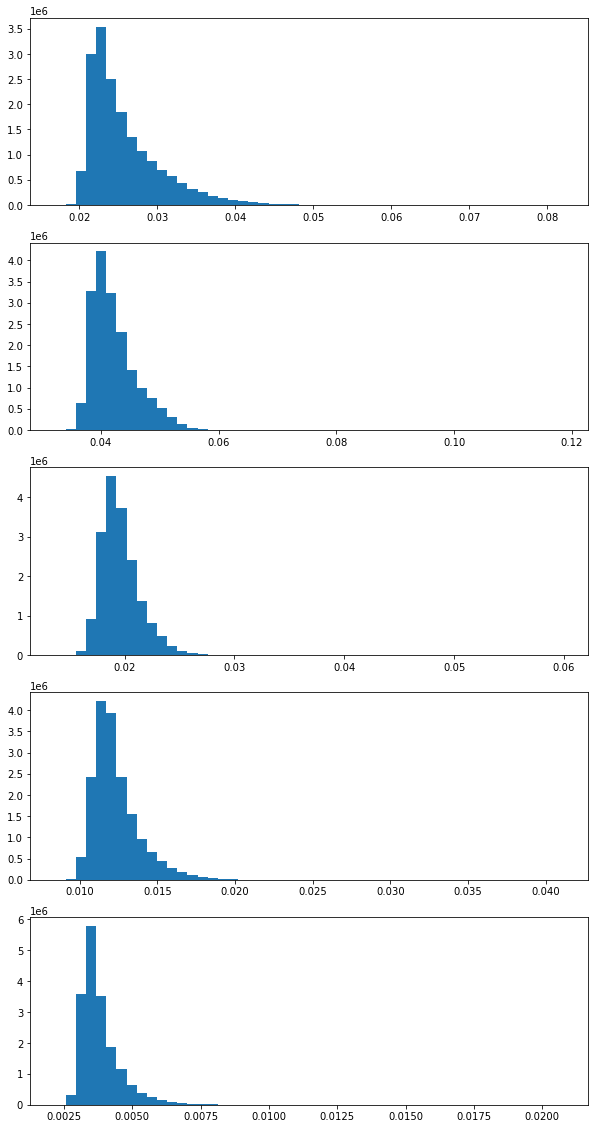

In [29]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(5,1, figsize=(10,20))

for i in range(0,5):
    ax[i].hist(all_imgs[:,i].flatten(), bins=50)
    #ax[i].set_xlim(0,0.060)
    #im = ax[i].imshow(all_imgs[0,i])
    #fig.colorbar(im, ax=ax[i])

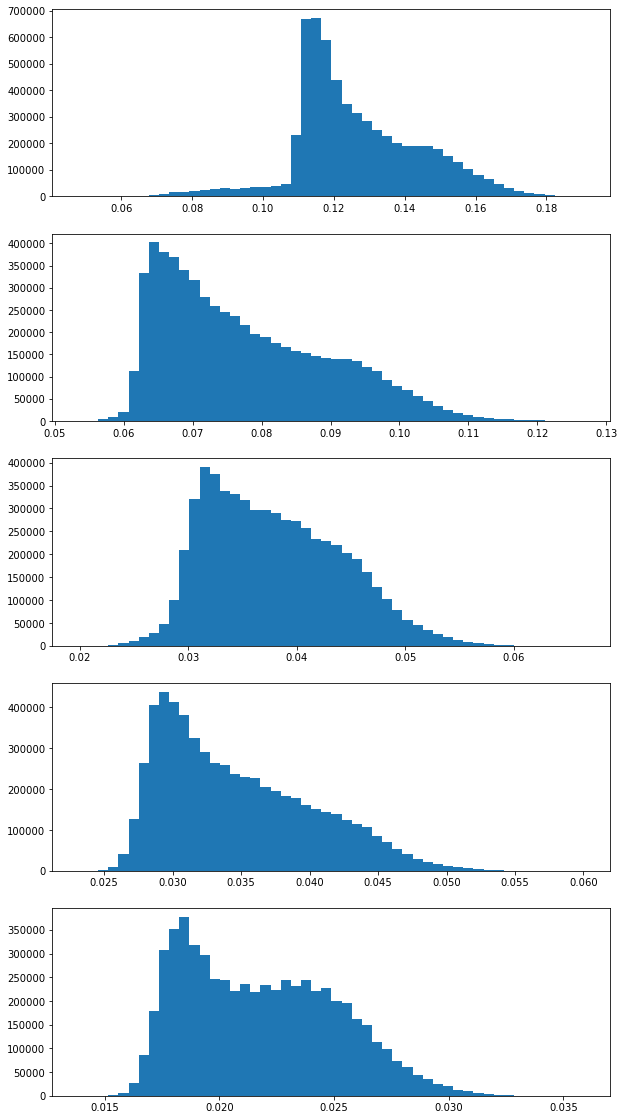

In [30]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(5,1, figsize=(10,20))

for i in range(0,5):
    ax[i].hist(all_sky_imgs[:,i].flatten(), bins=50)
    #ax[i].set_xlim(0,0.060)
    #im = ax[i].imshow(all_imgs[0,i])
    #fig.colorbar(im, ax=ax[i])

### Cut off the bright outliers

In [31]:
mean_lowest = []
list_of_spectra = []

for i in range(0,all_imgs.shape[0]):
#for i in range(0,40):
    nir_idx = 4
    # choose the percent to sort
    spectra = []
    lowest_percent = .65
    num_to_sort = int(all_imgs[i,nir_idx].size * lowest_percent)
    #print('sorting ', num_to_sort)
    nir_idx = 4
    
    # efficiently sort the array
    flat_array = all_imgs[i,nir_idx].flatten()
    flat_array[flat_array == 0 ] = 1
    #flat_array[flat_array < 0.0035 ] = 1
    idx = np.argpartition(flat_array, num_to_sort)[:num_to_sort]
    
    #plt.hist(flat_array[idx], density=True, bins=60)
    mean_of_subset_band = np.mean(flat_array[idx])
    mean_lowest.append(mean_of_subset_band)
    #plt.axvline(x=mean_of_subset_band)
    #plt.xlim(0,0.005)
    for img_idx in range(0,5):
        spectra.append(np.mean(all_imgs[i,img_idx].flatten()[idx]))
    list_of_spectra.append(spectra)

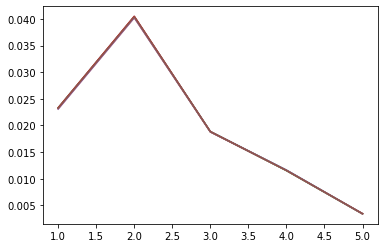

In [32]:
for spectra in list_of_spectra:
    plt.plot(range(1,6), spectra)

In [33]:
mean_lowest = []
list_of_sky_spectra = []

for i in range(0,all_sky_imgs.shape[0]):
#for i in range(0,40):
    nir_idx = 4
    # choose the percent to sort
    spectra = []
    lowest_percent = .65
    num_to_sort = int(all_sky_imgs[i,nir_idx].size * lowest_percent)
    #print('sorting ', num_to_sort)
    nir_idx = 4
    
    # efficiently sort the array
    flat_array = all_sky_imgs[i,nir_idx].flatten()
    flat_array[flat_array == 0 ] = 1
    #flat_array[flat_array < 0.0035 ] = 1
    idx = np.argpartition(flat_array, num_to_sort)[:num_to_sort]
    
    #plt.hist(flat_array[idx], density=True, bins=60)
    mean_of_subset_band = np.mean(flat_array[idx])
    mean_lowest.append(mean_of_subset_band)
    #plt.axvline(x=mean_of_subset_band)
    #plt.xlim(0,0.005)
    for img_idx in range(0,5):
        spectra.append(np.mean(all_sky_imgs[i,img_idx].flatten()[idx]))
    list_of_sky_spectra.append(spectra)

In [34]:
len(list_of_sky_spectra)

2

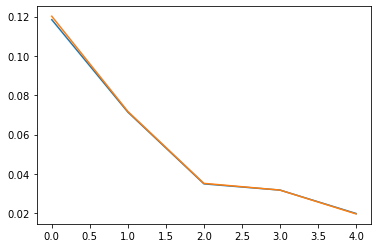

In [35]:
for ss in list_of_sky_spectra:
    plt.plot(range(0,5), ss)

In [36]:
band_names = ['blue', 'green', 'red', 'nir', 'red edge']

In [37]:
np.mean(list_of_sky_spectra,axis=0)

array([0.11932445, 0.07162436, 0.03509033, 0.0317988 , 0.01978293])

In [78]:
wind = 3 # m/s???
sky_spectra = np.mean(list_of_sky_spectra,axis=0)
water_leaving_spectra = []
for water_spec in list_of_spectra:
    water_leaving = np.array(water_spec) - np.array(sky_spectra) * (0.0256 + 0.00039 * wind + 0.000034 * wind * wind)
    water_leaving_spectra.append(water_leaving)

In [79]:
len(water_leaving_spectra)

1

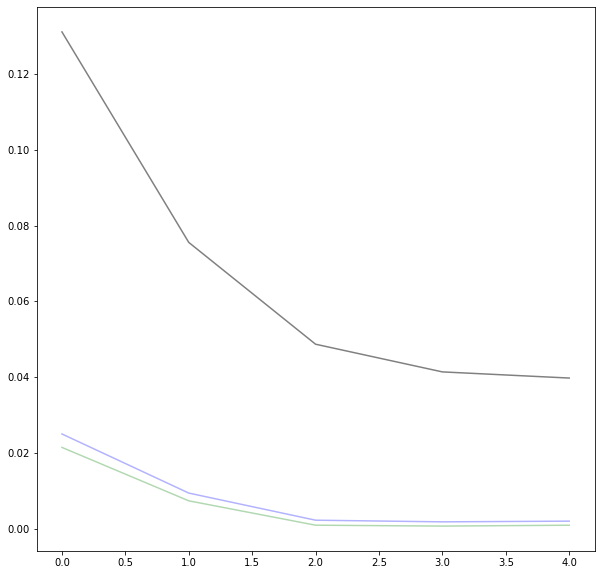

In [80]:
fig, ax = plt.subplots(figsize=(10,10))

for spectra in list_of_spectra:
    ax.plot(range(0,5), spectra, color='blue', alpha=0.3)
    
for spectra in water_leaving_spectra:
    ax.plot(range(0,5), spectra, color='green', alpha=0.3)
    
ax.plot(range(0,5), sky_spectra, color='grey')
#ax.plot(seaimgset.captures[capture_num].band_names_lower(), [0.13079345, 0.08020303, 0.05103283, 0.04054285, 0.04573154])

In [81]:
def L2chlor_a(Rrs443, Rrs488, Rrs547, Rrs555, Rrs667):
    ''' Use weighted MODIS Aqua bands to calculate chlorophyll concentration
    using oc3m blended algorithm with CI (Hu et al. 2012) '''

    thresh = [0.15, 0.20]
    a0 = 0.2424
    a1 = -2.7423
    a2 = 1.8017
    a3 = 0.0015
    a4 = -1.2280

    ci1 = -0.4909
    ci2 = 191.6590
    
    if Rrs443 > Rrs488:
        Rrsblue = Rrs443
    else:
        Rrsblue = Rrs488

    log10chl = a0 + a1 * (np.log10(Rrsblue / Rrs547)) \
        + a2 * (np.log10(Rrsblue / Rrs547))**2 \
            + a3 * (np.log10(Rrsblue / Rrs547))**3 \
                + a4 * (np.log10(Rrsblue / Rrs547))**4

    oc3m = np.power(10, log10chl)

    CI = Rrs555 - ( Rrs443 + (555 - 443)/(667 - 443) * \
        (Rrs667 -Rrs443) )
        
    ChlCI = 10** (ci1 + ci2*CI)

    if ChlCI <= thresh[0]:
        chlor_a = ChlCI
    elif ChlCI > thresh[1]:
        chlor_a = oc3m
    else:
        chlor_a = oc3m * (ChlCI-thresh[0]) / (thresh[1]-thresh[0]) +\
            ChlCI * (thresh[1]-ChlCI) / (thresh[1]-thresh[0])

    return chlor_a


In [82]:
chla_list = []
for spectra in water_leaving_spectra:
    chla = L2chlor_a(spectra[0],spectra[0],spectra[1],spectra[1],spectra[2])
    chla_list.append(chla)

In [83]:
chla_list

[0.05960075044229095]

In [84]:
img_metadata[0]

{'Latitude': 34.22859444444445,
 'Longitude': -76.37358055555555,
 'Altitude': 1.2,
 'UTC-Time': '16:29:58',
 'Date': '09/13/2020'}

In [85]:
# TODO need to filter out for bad lat and lon and bad chl values
# it seems like sometimes lat and long are 0

In [86]:
from datetime import datetime
chla_dates = []
for im in img_metadata:
    date_time_str = im['Date'] + ' ' + im['UTC-Time']

    date_time_obj = datetime.strptime(date_time_str, '%m/%d/%Y %H:%M:%S')
    chla_dates.append(date_time_obj)

In [93]:
lons = []
lats = []
for im in img_metadata:
    lons.append(im['Longitude'])
    lats.append(im['Latitude'])

Text(0.5, 0, 'Time')

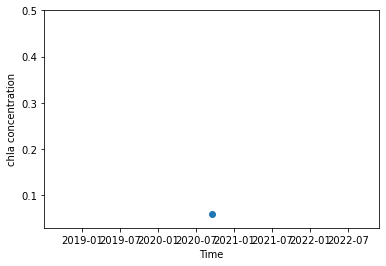

In [94]:
plt.scatter(chla_dates, chla_list)
plt.ylim(0.03,.5)
plt.ylabel('chla concentration')
plt.xlabel('Time')
#plt.savefig('chla_across_time.png', dpi=300)

Text(0.5, 0, 'Time')

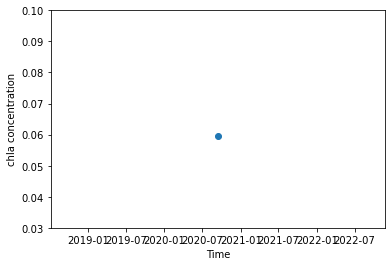

In [95]:
plt.scatter(chla_dates, chla_list)
plt.ylim(0.03,.1)
plt.ylabel('chla concentration')
plt.xlabel('Time')
#plt.savefig('chla_across_time_zoomed.png', dpi=300)

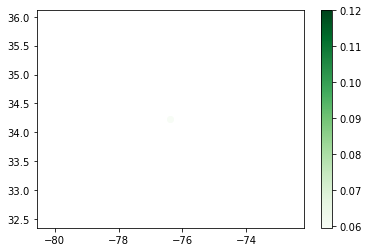

In [96]:
import matplotlib
plt.scatter(lons, lats, c=chla_list, cmap='Greens', vmax=0.12)
plt.colorbar()
#plt.savefig('chla_across_space.png', dpi=300)
plt.show()

<AxesSubplot:>

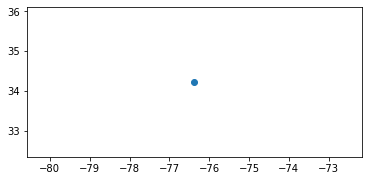

In [97]:
import pandas as pd
import geopandas as gpd
chla_df = pd.DataFrame(
    {'chla': chla_list,
     'Latitude': lats,
     'Longitude': lons,
     'time' : chla_dates})

chla_gdf = gpd.GeoDataFrame(
    chla_df, geometry=gpd.points_from_xy(chla_df.Longitude, chla_df.Latitude))
chla_gdf.plot()

In [98]:
chla_gdf.head()

,chla,Latitude,Longitude,time,geometry
0,0.059601,34.228594,-76.373581,2020-09-13 16:29:58,POINT (-76.37358 34.22859)


In [99]:
chla_gdf.time = chla_gdf.time.astype(str)
#chla_gdf.to_file('uas_data.shp')

### Calculate Chl-a Across the Whole Image

In [102]:
full_sea_img = all_imgs[0]

full_sea_img.shape,all_imgs.shape

((5, 947, 1271), (1, 5, 947, 1271))

In [108]:
full_sea_img_flat = full_sea_img.reshape(5,-1)
full_sea_img_flat.shape

(5, 1203637)

In [105]:
sky_spectra = list_of_sky_spectra[0]
sky_spectra

[0.13108726172807156,
 0.07554928596471715,
 0.0486882218751604,
 0.04138354558988668,
 0.03976019530017036]

In [110]:
sky_rad_correction = np.reshape(np.array(sky_spectra) * (0.0256 + 0.00039 * wind + 0.000034 * wind * wind), (5,1))
water_leaving = full_sea_img_flat - sky_rad_correction

In [111]:
water_leaving.shape

(5, 1203637)

In [112]:
chlas = []
for i in range(water_leaving.shape[-1]):
    chlas.append(L2chlor_a(water_leaving[0,i],water_leaving[0,i],water_leaving[1,i],water_leaving[1,i],water_leaving[2,i]))

In [113]:
chlas = np.array(chlas)

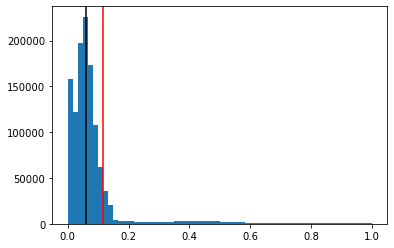

In [124]:
plt.hist(chlas, range=(0,1), bins=60)
plt.axvline(np.median(chlas), c='black')
plt.axvline(np.mean(chlas), c='red')
plt.show()

In [126]:
np.nanmax(chlas), np.median(chlas), np.mean(chlas)

(78.72411641317416, 0.0589523027350965, 0.1145209316457081)

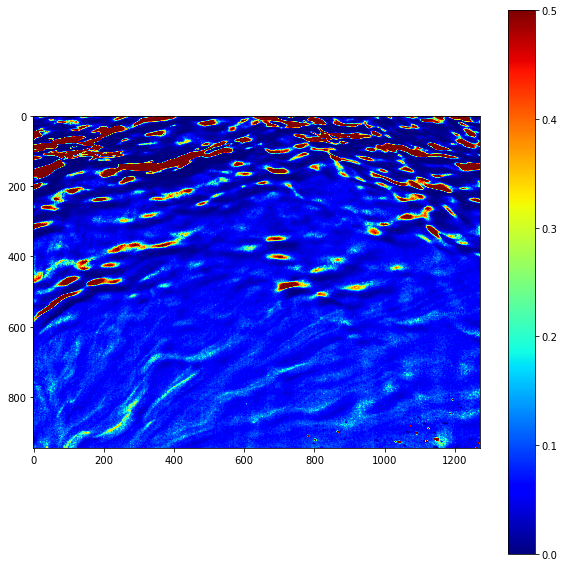

In [175]:
fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(np.reshape(chlas,(full_sea_img.shape[1], full_sea_img.shape[2])), vmin=0, vmax=.5, cmap='jet')
fig.colorbar(im)

In [151]:
selected_pix = np.zeros(flat_array.shape[0], dtype=np.int)
selected_pix[idx] = 1

In [152]:
np.unique(selected_pix)

array([0, 1])

In [153]:
len(flat_array)

1203637

In [154]:
len(chlas)

1203637

In [155]:
np.min(selected_pix), np.max(selected_pix)

(0, 1)

In [147]:
selected_pix[flat_array == 0 ] = 0
selected_pix[flat_array < 0.0035 ] = 0
selected_pix[flat_array > 1 ] = 0

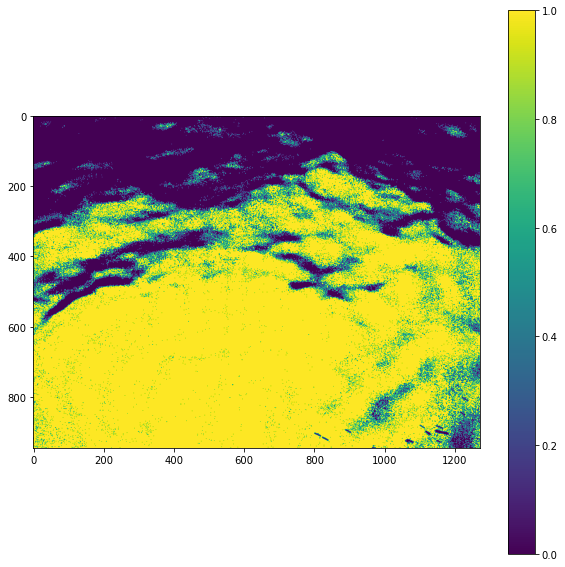

In [156]:
fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(np.reshape(selected_pix,(full_sea_img.shape[1], full_sea_img.shape[2])))
fig.colorbar(im)

In [157]:
chlas

array([0.17756032, 0.28951583, 0.42003198, ..., 0.03935788, 0.0447298 ,
       0.04981827])

In [160]:
chla_pix = np.zeros(flat_array.shape[0])
chla_pix[idx] = chlas[idx]

In [159]:
chla_pix[chla_pix > 25] = 25
chla_pix[flat_array < 0.0035 ] = 0
chla_pix[flat_array > 1 ] = 0

In [161]:
chla_pix[chla_pix == 0] = np.nan

In [162]:
np.nanmax(chla_pix)

78.72411641317416

In [163]:
np.nanmedian(chla_pix)

0.06348485039849452

<function matplotlib.pyplot.show(close=None, block=None)>

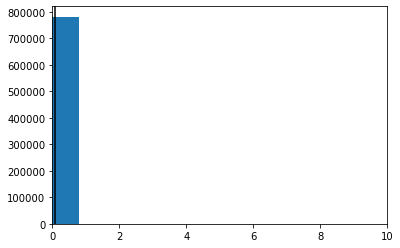

In [167]:
plt.hist(chla_pix, density=False, bins=100)
plt.axvline(x=np.nanmedian(chla_pix), color='black')
plt.xlim(0,10)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

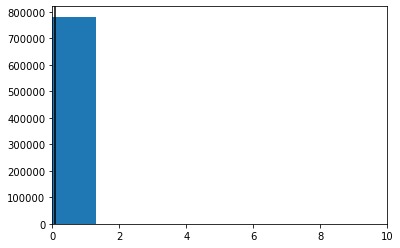

In [168]:
plt.hist(chla_pix, density=False, bins=60)
plt.axvline(x=np.nanmedian(chla_pix), color='black')
plt.xlim(0,10)
plt.show

In [622]:
np.count_nonzero(~np.isnan(chla_pix)) / chla_pix.size

0.09963948567708333

<function matplotlib.pyplot.show(close=None, block=None)>

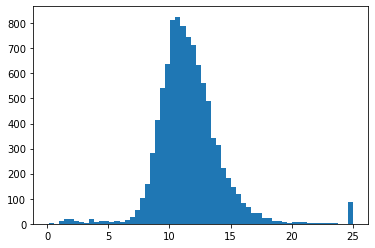

In [576]:
plt.hist(chla_pix, density=False, bins=60)
plt.show

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("jet"))
  after removing the cwd from sys.path.


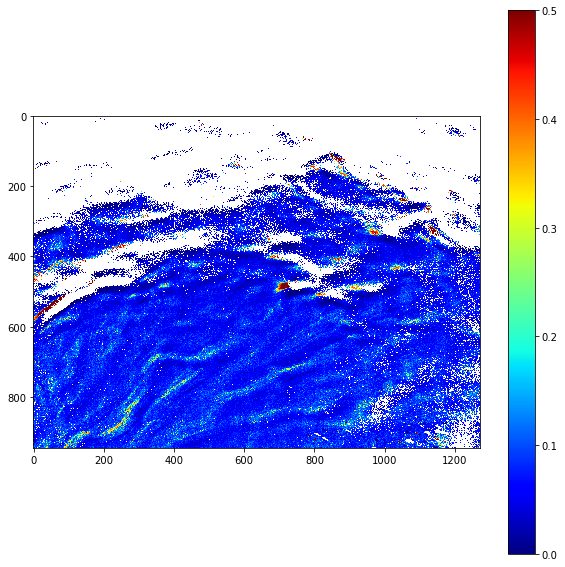

In [174]:
fig, ax = plt.subplots(figsize=(10,10))

cmap = matplotlib.cm.jet
cmap.set_bad('white',1.)

im = ax.imshow(np.reshape(chla_pix,(full_sea_img.shape[1], full_sea_img.shape[2])), vmin=0, vmax=.5, interpolation='nearest', cmap=cmap)
fig.colorbar(im)

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("jet"))
  after removing the cwd from sys.path.


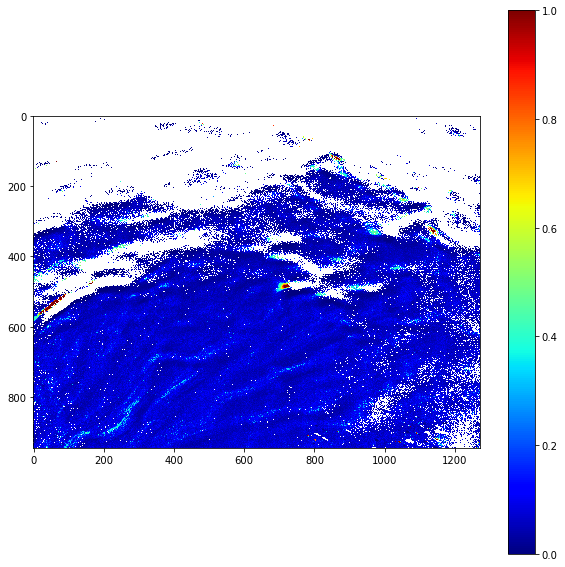

In [173]:
fig, ax = plt.subplots(figsize=(10,10))

cmap = matplotlib.cm.jet
cmap.set_bad('white',1.)

im = ax.imshow(np.reshape(chla_pix,(full_sea_img.shape[1], full_sea_img.shape[2])), vmin=0, vmax=1, interpolation='nearest', cmap=cmap)
fig.colorbar(im)